In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import re

### Load Dataset

In [2]:
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
df.text[0]

'@VirginAmerica What @dhepburn said.'

In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

### Data Exploration

In [6]:
tweets_count = df['airline'].value_counts()
tweets_count

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

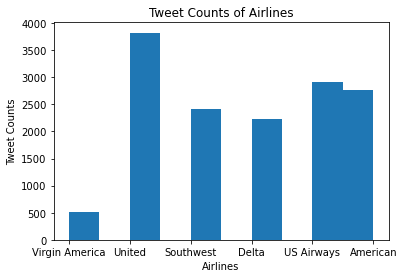

In [7]:
fig,ax = plt.subplots(1,1) 
ax.hist(df['airline'])
ax.set_title("Tweet Counts of Airlines")
ax.set_xlabel('Airlines')
ax.set_ylabel('Tweet Counts')
plt.show()

In [8]:
sentiments = df['airline_sentiment'].value_counts()
sentiments

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

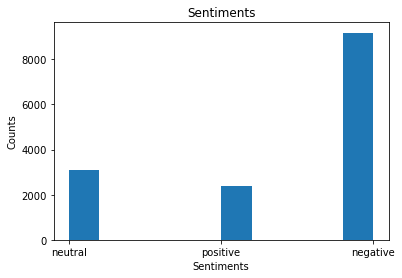

In [9]:
fig,ax = plt.subplots(1,1) 
ax.hist(df['airline_sentiment'])
ax.set_title("Sentiments")
ax.set_xlabel('Sentiments')
ax.set_ylabel('Counts')
plt.show()

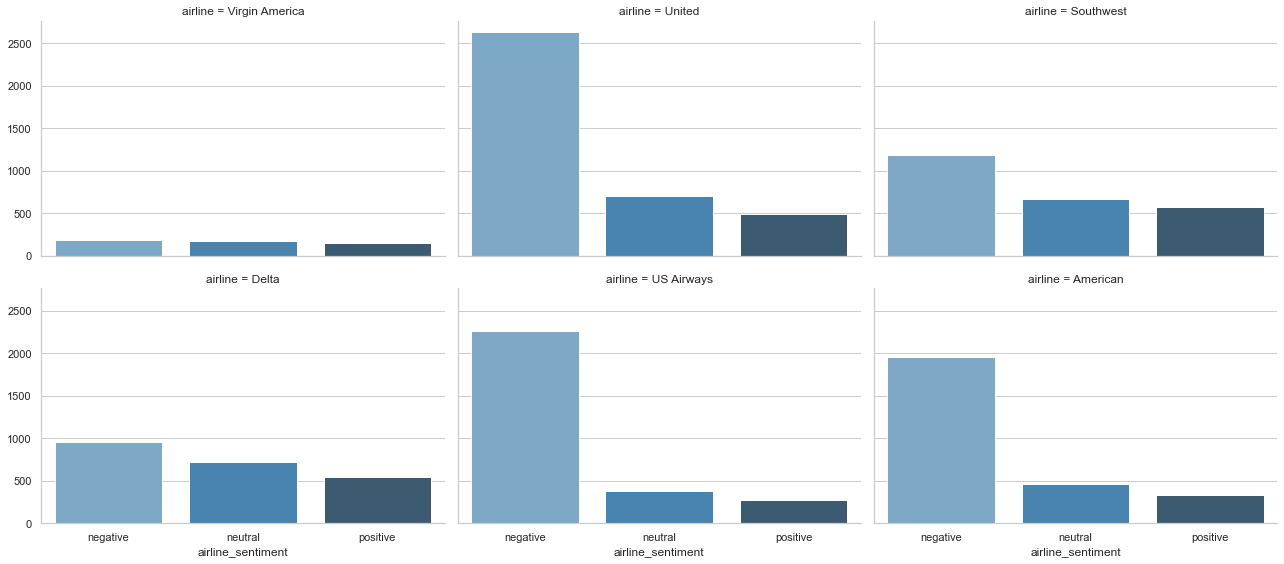

In [10]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
sentiment_plot = sns.FacetGrid(df, col="airline",col_wrap=3, height=4, aspect =1.5) 
sentiment_plot = sentiment_plot.map(sns.countplot, "airline_sentiment",order =df.airline_sentiment.value_counts().index, palette='Blues_d') 
plt.show()

### Feature selection

In [11]:
tweets=df[["text","airline_sentiment"]]

In [12]:
tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [13]:
tweets.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

In [14]:
tweets.shape

(14640, 2)

In [15]:
tweets.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

In [16]:
tweets.shape

(14640, 2)

In [17]:
#for binary classification 
tweet_final=tweets[tweets["airline_sentiment"]!="neutral"]

In [18]:
tweet_final

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
...,...,...
14633,@AmericanAir my flight was Cancelled Flightled...,negative
14634,@AmericanAir right on cue with the delays👌,negative
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative


In [19]:
tweet_final["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [20]:
# converting labels into integer
sentiment_label = tweet_final.airline_sentiment.factorize()

In [21]:
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

### Word Embedding 

In [22]:
# text into array
tweet_data=tweet_final["text"].values

In [23]:
tweet_data

array(["@VirginAmerica plus you've added commercials to the experience... tacky.",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it", ...,
       '@AmericanAir thank you we got on a different flight to Chicago.',
       "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc",
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"],
      dtype=object)

### Tokenization 

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet_data)

In [26]:
# encode data
encoded_data = tokenizer.texts_to_sequences(tweet_data)


In [27]:
# vocab size is length of vocabaloury
vocab_size = len(tokenizer.word_index) + 1

In [28]:
tokenizer.word_index

{'to': 1,
 'the': 2,
 'i': 3,
 'a': 4,
 'united': 5,
 'you': 6,
 'for': 7,
 'flight': 8,
 'and': 9,
 'on': 10,
 'my': 11,
 'usairways': 12,
 'americanair': 13,
 'is': 14,
 'in': 15,
 'southwestair': 16,
 'of': 17,
 'jetblue': 18,
 'me': 19,
 'your': 20,
 'it': 21,
 'was': 22,
 'not': 23,
 'no': 24,
 'have': 25,
 'at': 26,
 'with': 27,
 'that': 28,
 'this': 29,
 'get': 30,
 'but': 31,
 'be': 32,
 'cancelled': 33,
 'thanks': 34,
 'now': 35,
 'service': 36,
 'are': 37,
 'we': 38,
 'from': 39,
 'an': 40,
 'been': 41,
 'just': 42,
 '2': 43,
 'so': 44,
 'customer': 45,
 'help': 46,
 't': 47,
 'can': 48,
 'time': 49,
 'co': 50,
 'up': 51,
 'hours': 52,
 'http': 53,
 'do': 54,
 'hold': 55,
 'they': 56,
 'out': 57,
 'amp': 58,
 'plane': 59,
 "i'm": 60,
 'us': 61,
 'all': 62,
 'will': 63,
 'why': 64,
 'thank': 65,
 'still': 66,
 'our': 67,
 'delayed': 68,
 'what': 69,
 'when': 70,
 'how': 71,
 'one': 72,
 "can't": 73,
 'flights': 74,
 'call': 75,
 'gate': 76,
 'hour': 77,
 'had': 78,
 'flightled

In [29]:
# padding for equal dimensions
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_data, maxlen=200)

### Model 

In [31]:
# text classifier with squencia model
# Creating model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding



embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

### Training model 

In [33]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 63s 205ms/step - loss: 0.3971 - accuracy: 0.8332 - val_loss: 0.1994 - val_accuracy: 0.9233
Epoch 2/5
289/289 [==============================] - 59s 205ms/step - loss: 0.2172 - accuracy: 0.9177 - val_loss: 0.1616 - val_accuracy: 0.9428
Epoch 3/5
289/289 [==============================] - 60s 208ms/step - loss: 0.1660 - accuracy: 0.9376 - val_loss: 0.1615 - val_accuracy: 0.9446
Epoch 4/5
289/289 [==============================] - 58s 200ms/step - loss: 0.1350 - accuracy: 0.9491 - val_loss: 0.1588 - val_accuracy: 0.9472
Epoch 5/5
289/289 [==============================] - 60s 206ms/step - loss: 0.1163 - accuracy: 0.9573 - val_loss: 0.1741 - val_accuracy: 0.9472


In [34]:
history

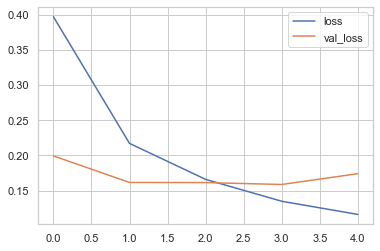

<Figure size 432x288 with 0 Axes>

In [35]:
# Plot between losss ana Val_loss

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

### Accuracy

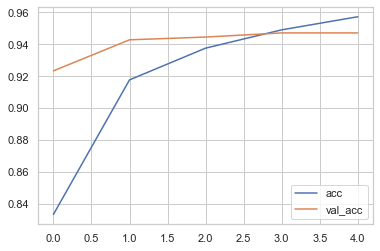

<Figure size 432x288 with 0 Axes>

In [36]:
# plot between acrruacy and val_accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

### Prediction

In [38]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [39]:
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

Predicted label:  positive


In [40]:
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  negative
